# Sequential Minimal Optimization

This notebook implements SMO as introduced in "Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines" by John C. Platt.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions

%matplotlib widget

def linear_kernel(x1, x2):
    return x1.T @ x2


class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x) - self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta < 0:
            a2 = alpha2 + y2 * (e2 - e1) / eta
            if a2 >= H:
                a2 = H
            elif a2 <= L:
                a2 = L
            else:
                a2 = a2
        # TODO: the negative case
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        #if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        #a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [11]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


In [12]:
model = svm(c=5.0)
model.fit(samples, targets)
print(model._weights)
print(model._b)

[DEBUG] smo_step: eta = 0.7179220362093313
[DEBUG] smo_step: eta = 9.22803007005341
[DEBUG] smo_step: eta = 0.10265813270403212
[DEBUG] smo_step: eta = 0.22542766039288953
[DEBUG] smo_step: eta = 8.112906510203343
[DEBUG] smo_step: eta = 0.29805158272914234
[DEBUG] smo_step: eta = 6.360787009999154
[DEBUG] smo_step: eta = 0.35566787982641834
[DEBUG] smo_step: eta = 9.246865325619112
[DEBUG] smo_step: eta = 0.38956652973413597
[DEBUG] smo_step: eta = 0.4538737098451846
[DEBUG] smo_step: eta = 0.2962044618386517
[DEBUG] smo_step: eta = 0.10147445878719985
[DEBUG] smo_step: eta = 0.08583110376033876
[DEBUG] smo_step: eta = 9.227709710463927
[DEBUG] smo_step: eta = 6.256265578714222
[DEBUG] smo_step: eta = 0.3194710408348358
[DEBUG] smo_step: eta = 10.180701080072524
[DEBUG] smo_step: eta = 5.998417532130647
[DEBUG] smo_step: eta = 7.714453091977394
[DEBUG] smo_step: eta = 7.345613304580796
[DEBUG] smo_step: eta = 0.12106930587382969
[DEBUG] smo_step: eta = 0.2103845816490617
[DEBUG] smo_s

[DEBUG] smo_step: eta = 10.776530174665025
[DEBUG] smo_step: eta = 6.649713508054784
[DEBUG] smo_step: eta = 9.208258529418288
[DEBUG] smo_step: eta = 7.038833165345034
[DEBUG] smo_step: eta = 10.915020456928023
[DEBUG] smo_step: eta = 11.353638799005838
[DEBUG] smo_step: eta = 8.171871756793404
[DEBUG] smo_step: eta = 9.238315472452008
[DEBUG] smo_step: eta = 9.21039916989741
[DEBUG] smo_step: eta = 9.56918729114488
[DEBUG] smo_step: eta = 10.970222842936458
[DEBUG] smo_step: eta = 11.883026182666487
[DEBUG] smo_step: eta = 9.601503407916603
[DEBUG] smo_step: eta = 5.36515175787174
[DEBUG] smo_step: eta = 10.374521979046987
[DEBUG] smo_step: eta = 8.43062748785049
[DEBUG] smo_step: eta = 7.24334235517582
[DEBUG] smo_step: eta = 9.52501312123749
[DEBUG] smo_step: eta = 12.21901122917589
[DEBUG] smo_step: eta = 10.811952230094267
[DEBUG] smo_step: eta = 0.319147824512509
[DEBUG] smo_step: eta = 7.65538015819719
[DEBUG] smo_step: eta = 0.08583110376033876
[DEBUG] smo_step: eta = 0.107371

[DEBUG] smo_step: eta = 7.10924404920087
[DEBUG] smo_step: eta = 8.07318082651381
[DEBUG] smo_step: eta = 6.128185883002017
[DEBUG] smo_step: eta = 2.992941453471042
[DEBUG] smo_step: eta = 6.6162777371359445
[DEBUG] smo_step: eta = 5.151186562504089
[DEBUG] smo_step: eta = 4.274534677310816
[DEBUG] smo_step: eta = 5.916195807942818
[DEBUG] smo_step: eta = 8.416284643986671
[DEBUG] smo_step: eta = 6.991826834776324
[DEBUG] smo_step: eta = 0.7179220362093313
[DEBUG] smo_step: eta = 13.795074275599307
[DEBUG] smo_step: eta = 1.4230287712953027
[DEBUG] smo_step: eta = 0.23218239071616242
[DEBUG] smo_step: eta = 11.952330774803407
[DEBUG] smo_step: eta = 7.73890786520108
[DEBUG] smo_step: eta = 11.83761024774075
[DEBUG] smo_step: eta = 12.975766900535437
[DEBUG] smo_step: eta = 1.135732007871637
[DEBUG] smo_step: eta = 1.4817480375687078
[DEBUG] smo_step: eta = 13.961878535182882
[DEBUG] smo_step: eta = 11.58790260430614
[DEBUG] smo_step: eta = 12.596916617060948
[DEBUG] smo_step: eta = 12

[DEBUG] smo_step: eta = 9.183273661965803
[DEBUG] smo_step: eta = 9.893124285825808
[DEBUG] smo_step: eta = 11.641859899333811
[DEBUG] smo_step: eta = 6.882849682895721
[DEBUG] smo_step: eta = 5.809540077298069
[DEBUG] smo_step: eta = 0.0249622410476249
[DEBUG] smo_step: eta = 0.43503835384501155
[DEBUG] smo_step: eta = 0.0811293556564836
[DEBUG] smo_step: eta = 0.20860265174593629
[DEBUG] smo_step: eta = 8.651875666919164
[DEBUG] smo_step: eta = 10.815846222379328
[DEBUG] smo_step: eta = 10.400318416571768
[DEBUG] smo_step: eta = 0.019027334023373754
[DEBUG] smo_step: eta = 0.510366392043939
[DEBUG] smo_step: eta = 12.480108975112376
[DEBUG] smo_step: eta = 1.2325451056211918
[DEBUG] smo_step: eta = 0.4439950799981669
[DEBUG] smo_step: eta = 0.3906235161719289
[DEBUG] smo_step: eta = 0.03352870971798616
[DEBUG] smo_step: eta = 9.646352059402863
[DEBUG] smo_step: eta = 0.07142192342677944
[DEBUG] smo_step: eta = 11.330178717907375
[DEBUG] smo_step: eta = 0.2890406695471377
[DEBUG] smo_

[DEBUG] smo_step: eta = 0.11929778207028985
[DEBUG] smo_step: eta = 0.012315383535016267
[DEBUG] smo_step: eta = 0.2570829312921221
[DEBUG] smo_step: eta = 0.2371321784837197
[DEBUG] smo_step: eta = 0.017466881083385566
[DEBUG] smo_step: eta = 0.5067828587736605
[DEBUG] smo_step: eta = 0.07410620021212377
[DEBUG] smo_step: eta = 0.3587398557952084
[DEBUG] smo_step: eta = 0.17128968002989442
[DEBUG] smo_step: eta = 0.31801603507188414
[DEBUG] smo_step: eta = 0.39622420346423937
[DEBUG] smo_step: eta = 0.33964657588902014
[DEBUG] smo_step: eta = 0.4479795001628508
[DEBUG] smo_step: eta = 0.14657271294285978
[DEBUG] smo_step: eta = 0.02007472287681722
[DEBUG] smo_step: eta = 0.22994051709678498
[DEBUG] smo_step: eta = 0.18491952694017844
[DEBUG] smo_step: eta = 0.2474169804883255
[DEBUG] smo_step: eta = 0.03697760694881769
[DEBUG] smo_step: eta = 0.6791421392040724
[DEBUG] smo_step: eta = 0.15206735720204279
[DEBUG] smo_step: eta = 0.8496782329744628
[DEBUG] smo_step: eta = 0.246680661641

[DEBUG] smo_step: eta = 6.615784550911744
[DEBUG] smo_step: eta = 7.671154164379091
[DEBUG] smo_step: eta = 0.07260939427054147
[DEBUG] smo_step: eta = 0.1075392959696666
[DEBUG] smo_step: eta = 0.024403491397733568
[DEBUG] smo_step: eta = 0.12139042843180947
[DEBUG] smo_step: eta = 8.135132949623236
[DEBUG] smo_step: eta = 9.057874769366608
[DEBUG] smo_step: eta = 5.722944103679387
[DEBUG] smo_step: eta = 0.04199318423316356
[DEBUG] smo_step: eta = 5.228833562534967
[DEBUG] smo_step: eta = 0.08114788258266259
[DEBUG] smo_step: eta = 0.13895821165220568
[DEBUG] smo_step: eta = 4.071836512860196
[DEBUG] smo_step: eta = 0.2465531827707781
[DEBUG] smo_step: eta = 0.516751666141356
[DEBUG] smo_step: eta = 0.307797269953336
[DEBUG] smo_step: eta = 8.389194068244656
[DEBUG] smo_step: eta = 9.940393549966211
[DEBUG] smo_step: eta = 7.4328624011420565
[DEBUG] smo_step: eta = 9.126633047574153
[DEBUG] smo_step: eta = 0.07781854002030553
[DEBUG] smo_step: eta = 0.4622937991672815
[DEBUG] smo_ste

[DEBUG] smo_step: eta = 12.196575117644494
[DEBUG] smo_step: eta = 5.603478547413619
[DEBUG] smo_step: eta = 10.997414008905624
[DEBUG] smo_step: eta = 12.619894190475828
[DEBUG] smo_step: eta = 7.558896741674765
[DEBUG] smo_step: eta = 13.20063485331384
[DEBUG] smo_step: eta = 10.01164710271895
[DEBUG] smo_step: eta = 11.982573781341248
[DEBUG] smo_step: eta = 7.0895351764773
[DEBUG] smo_step: eta = 10.58637662880528
[DEBUG] smo_step: eta = 10.553505636835727
[DEBUG] smo_step: eta = 11.929715510835926
[DEBUG] smo_step: eta = 11.889147036957542
[DEBUG] smo_step: eta = 10.175205757223868
[DEBUG] smo_step: eta = 7.900568545587221
[DEBUG] smo_step: eta = 0.13391753808504347
[DEBUG] smo_step: eta = 1.7847254379139441
[DEBUG] smo_step: eta = 0.3882339047872243
[DEBUG] smo_step: eta = 0.8326049729783058
[DEBUG] smo_step: eta = 0.17217470616718344
[DEBUG] smo_step: eta = 0.37412022686734847
[DEBUG] smo_step: eta = 0.3205636889571917
[DEBUG] smo_step: eta = 0.23232809909449958
[DEBUG] smo_step

[DEBUG] smo_step: eta = 0.4408476268266046
[DEBUG] smo_step: eta = 8.411328690530647
[DEBUG] smo_step: eta = 5.459608790253842
[DEBUG] smo_step: eta = 0.9028931967600435
[DEBUG] smo_step: eta = 9.998343387397426
[DEBUG] smo_step: eta = 2.3708074590408437
[DEBUG] smo_step: eta = 8.243515935901739
[DEBUG] smo_step: eta = 0.15778892515521026
[DEBUG] smo_step: eta = 12.42954626049229
[DEBUG] smo_step: eta = 5.384167131983421
[DEBUG] smo_step: eta = 0.8726951941905989
[DEBUG] smo_step: eta = 10.247987219952433
[DEBUG] smo_step: eta = 5.494738709369454
[DEBUG] smo_step: eta = 0.6674829025053413
[DEBUG] smo_step: eta = 4.20933973160281
[DEBUG] smo_step: eta = 10.049788294891858
[DEBUG] smo_step: eta = 6.04529519499985
[DEBUG] smo_step: eta = 1.4216217790881491
[DEBUG] smo_step: eta = 9.383966154236056
[DEBUG] smo_step: eta = 6.705237120868487
[DEBUG] smo_step: eta = 0.6580726895939586
[DEBUG] smo_step: eta = 6.720893037119328
[DEBUG] smo_step: eta = 0.9810887652096145
[DEBUG] smo_step: eta = 

[DEBUG] smo_step: eta = 0.41704478480195917
[DEBUG] smo_step: eta = 0.004569071492462662
[DEBUG] smo_step: eta = 0.08137790133059486
[DEBUG] smo_step: eta = 0.020637561923669168
[DEBUG] smo_step: eta = 0.030637794997338652
[DEBUG] smo_step: eta = 0.1490289504588329
[DEBUG] smo_step: eta = 0.17095427321734746
[DEBUG] smo_step: eta = 0.16571170090840592
[DEBUG] smo_step: eta = 0.05085486127575933
[DEBUG] smo_step: eta = 0.8214988529223879
[DEBUG] smo_step: eta = 0.06693929748257066
[DEBUG] smo_step: eta = 0.04069901184574576
[DEBUG] smo_step: eta = 0.14712814394809648
[DEBUG] smo_step: eta = 0.05888199170112074
[DEBUG] smo_step: eta = 0.11597833811732183
[DEBUG] smo_step: eta = 0.6087093751263288
[DEBUG] smo_step: eta = 0.22994013313909312
[DEBUG] smo_step: eta = 0.0639409283413066
[DEBUG] smo_step: eta = 0.6447557984160968
[DEBUG] smo_step: eta = 0.33290428525908133
[DEBUG] smo_step: eta = 0.6793848688235493
[DEBUG] smo_step: eta = 0.11857191598679861
[DEBUG] smo_step: eta = 0.526755947

weights=[0.28776875 0.79762071]
b=0


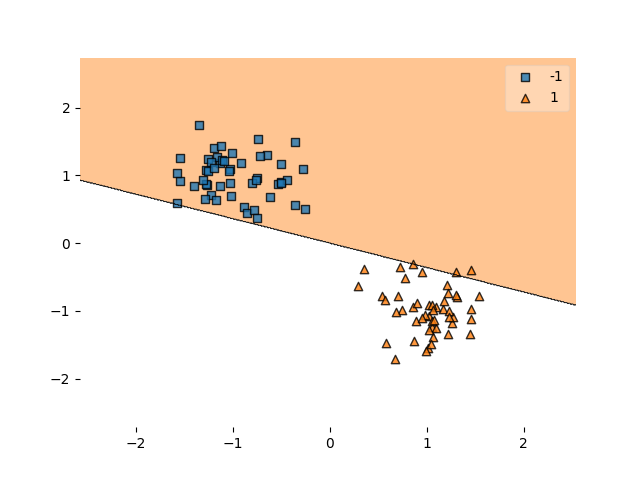

In [13]:
#SVM Model

print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

coef_=[[ 0.78127126 -1.0013519 ]]
intercept=[0.01090187]


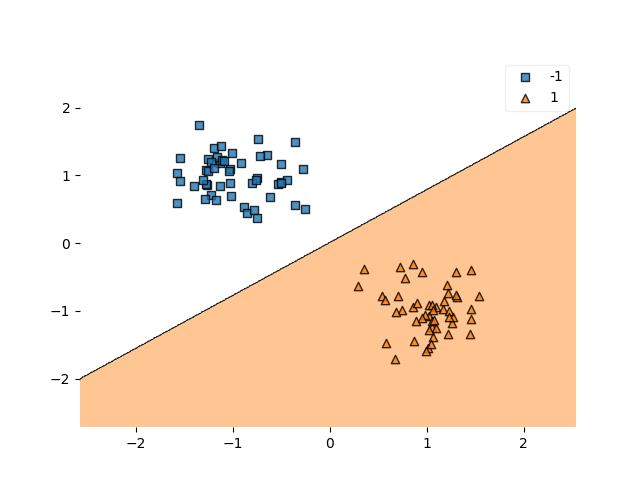

In [14]:
from sklearn.svm import LinearSVC


sk_model = LinearSVC()
sk_model.fit(samples, targets.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()